In [ ]:
from pyabc import History
from pyabc.visualization import plot_kde_matrix, kde_1d
import pyabc.visualization
import scipy.stats as st
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Inferring neonic toxicity from feeding study data and the VarroaPop+Pesticide model

#### 4/5/19 update

## Approximate Bayesian Computation with SMC sampling

We have reanalyzed the model with the following changes:
* 60% pupae -> adult transition to fit control data
* Account for unobserved active foragers
* Now fitting the model to # of eggs in addition to # of adults


In [2]:
#retrieve stored run
database_dir = 'results_db/'
db_path = ("sqlite:///" + os.path.join(database_dir, "run_3_11.db"))
history = History(db_path)
history.id = 1

In [3]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2019-03-11 16:56:05.391511,0,0.000000,1
1,0,2019-03-12 07:09:25.752604,963,244111.638117,500
2,1,2019-03-13 05:03:42.477176,1161,221549.142742,500
3,2,2019-03-14 06:47:42.578726,1404,210220.408074,500
4,3,2019-03-16 04:11:05.040127,1692,202346.625814,500
5,4,2019-03-19 14:59:39.152900,2649,194696.817142,500
6,5,2019-03-21 02:37:31.727082,3167,189350.870015,500
7,6,2019-03-24 16:08:47.254159,4587,185265.327136,500
8,7,2019-03-26 21:18:09.247548,5545,181547.706854,500
9,8,2019-03-29 13:28:17.235730,6906,178496.458997,500


In [4]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}%".format(gen+1,particles/samples*100))

Acceptance rates
Gen 1: 51.9%
Gen 2: 43.1%
Gen 3: 35.6%
Gen 4: 29.6%
Gen 5: 18.9%
Gen 6: 15.8%
Gen 7: 10.9%
Gen 8: 9.0%
Gen 9: 7.2%
Gen 10: 5.3%


We can also see that the posteriors clearly get more defined with each generation:

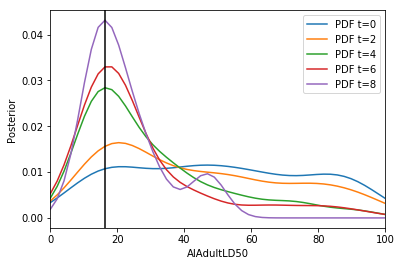

In [7]:
variable = 'AIAdultLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,2):
    df, w = history.get_distribution(m=0, t=t)
    df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
    df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=100,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
plt.show()

## Results

#### Let's look at the posterior for our model parameters. This will tell is the probability of each parameter value, given the feeding study data.


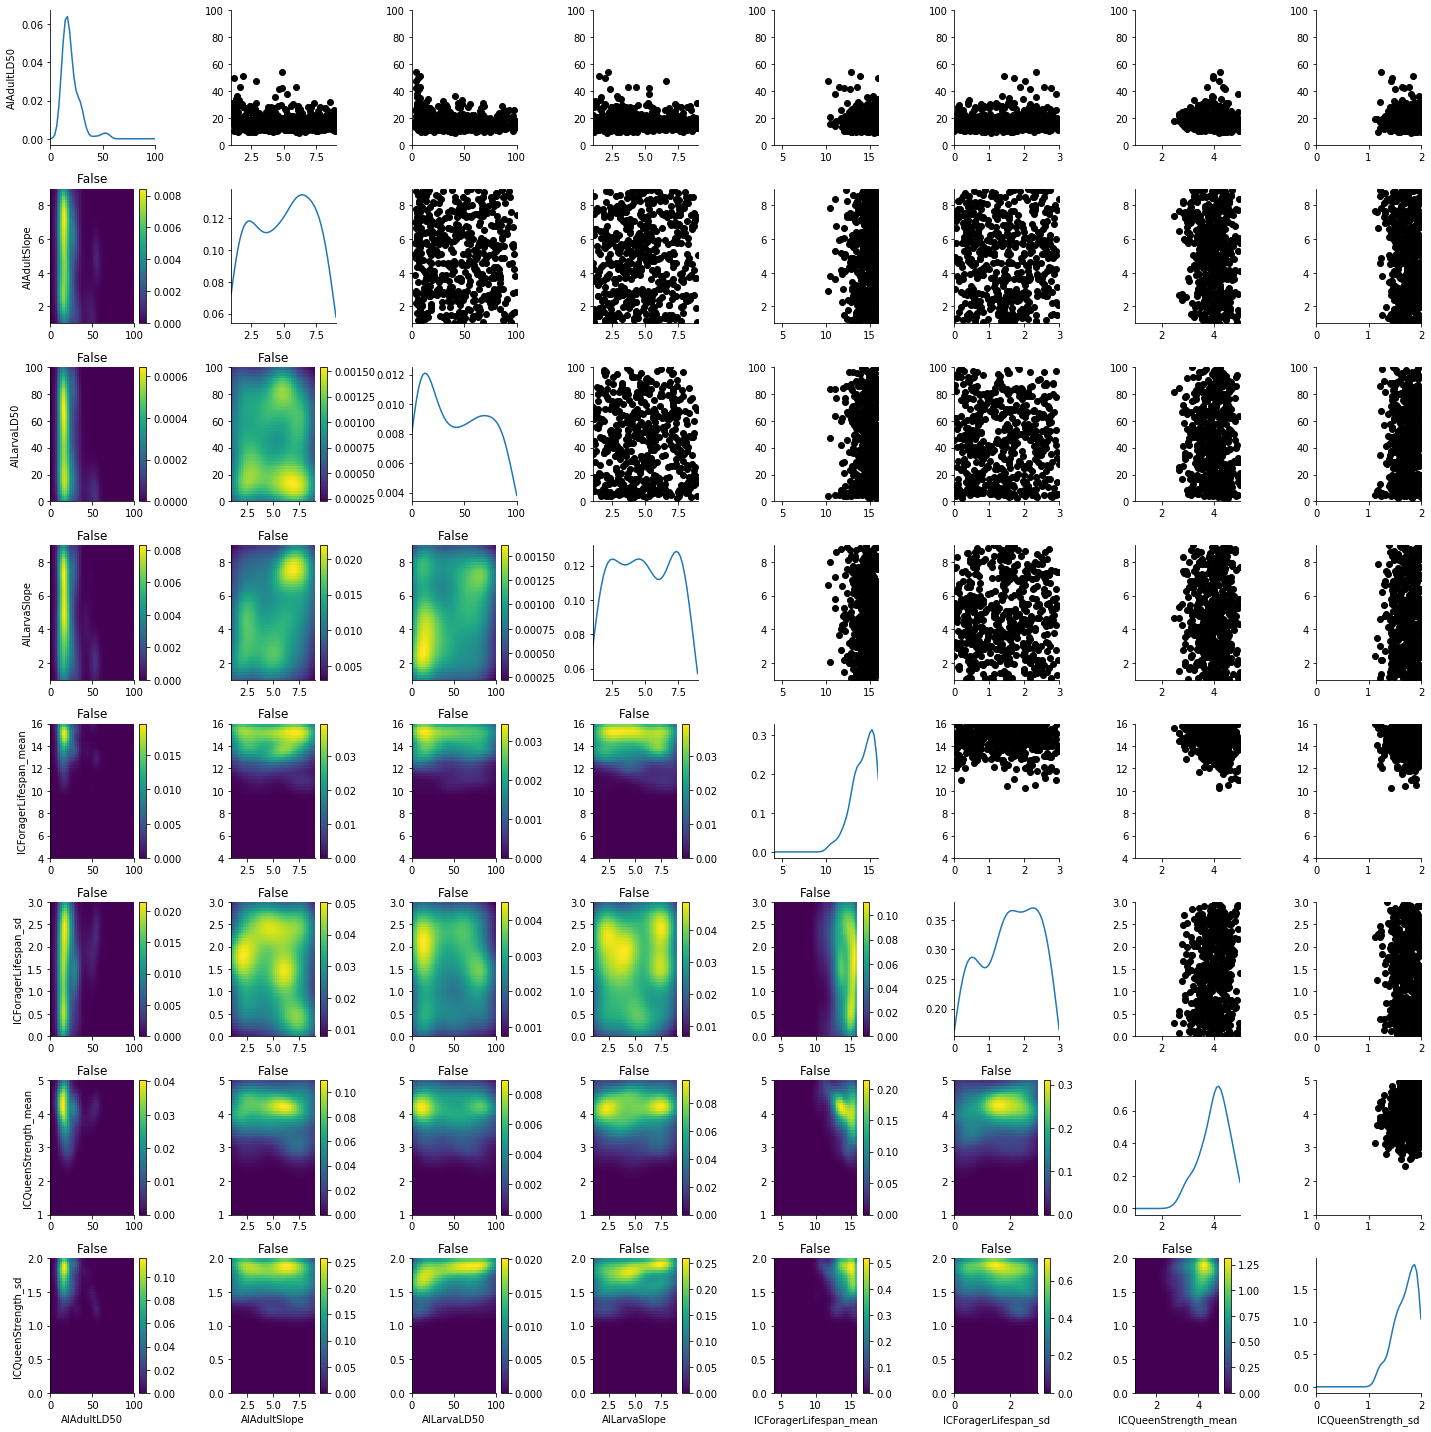

In [8]:
# Limits for the plots 
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0, 100), #log transformed 
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0,100), #log transformed
              AILarvaSlope=(1, 9))

t = history.max_t
df, w = history.get_distribution(m=0, t=t)
df["AIAdultLD50"] = df["AIAdultLD50"].copy() *1000
df["AILarvaLD50"] = df["AILarvaLD50"].copy() *1000
plot_kde_matrix(df, w, limits=limits);

#### Let's look at our predictions for LD50

In [12]:
## Define convenience functions for characterizing marginal distributions
def get_ci(variable, df, w, interval = 95):
    """
    Extract 95% credible intervals for a single parameter weighted posterior samples
    """
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    lower = (x.item(np.min(np.where(cdf > .025))))
    upper = (x.item(np.min(np.where(cdf > .975))))
    return lower, upper

def get_MAP(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    MAP = x[np.where(np.max(pdf)==pdf)]
    return MAP.item()

def get_mean(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    mean = np.average(x, weights=pdf)
    return mean

def get_sd(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    sd = np.sqrt(np.cov(x, aweights=pdf))
    return sd
    
def get_median(variable, df, w):
    x, pdf = kde_1d(df,w,variable, numx = 200)
    cdf = np.cumsum(pdf) / np.sum(pdf)
    median = (x.item(np.min(np.where(cdf > .5))))
    return median

def describe_marginal(variable, df, w, units = None):
    lower, upper = get_ci(variable, df, w)
    sd = get_sd(variable, df, w)
    MAP = get_MAP(variable, df, w)
    mean = get_mean(variable, df, w)
    median = get_median(variable, df, w)
    unit_str = ""
    if units:
        unit_str = units
    print("Descriptive statistics for {}:".format(variable))
    print("Mean: {:.2f} {}".format(mean, unit_str))
    print("SD: {:.2f} {}".format(sd, unit_str))
    print("Median {:.2f} {}".format(median, unit_str))
    print("MAP: {:.2f} {}".format(MAP, unit_str))
    print("95% CI: {:.2f} - {:.2f} {}".format(lower, upper, unit_str))

In [13]:
describe_marginal("AIAdultLD50", df, w, units = "ng/bee")
print()
describe_marginal("AILarvaLD50", df, w, units = "ng/bee")
print()

Descriptive statistics for AIAdultLD50:
Mean: 19.83 ng/bee
SD: 8.20 ng/bee
Median 18.04 ng/bee
MAP: 15.52 ng/bee
95% CI: 9.79 - 44.64 ng/bee

Descriptive statistics for AILarvaLD50:
Mean: 46.88 ng/bee
SD: 27.78 ng/bee
Median 46.01 ng/bee
MAP: 12.30 ng/bee
95% CI: 4.49 - 95.34 ng/bee



### We can use the posterior to make predictions about neonic toxicity and hive health

In [14]:
#define some functions to do our sampling and plotting

def draw_posterior(df, w, n=1):
    indices = df.index
    draws = random.choices(population=indices, weights = w, k=n)
    return df.loc[draws,:]

def plot_all_dr(sample, xlim=100, max_dose=100, adult=True, title='Dose-response curve',):
    fix, ax = plt.subplots()
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    ld50_col, slope_col = 0, 1
    if not adult:
        ld50_col, slope_col = ld50_col+2, slope_col+2
    for index, row in sample.iterrows():
        ld50 = row[ld50_col]
        slope = row[slope_col]
        y = 100/(1+(ld50/x)**slope) #four parameters Hill equation
        ax.plot(x, y, 'k',alpha=0.05)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    plt.show()
    
def get_prediction_interval(sample_in, percent=95, max_dose=100, adult=True):
    """
    Get PIs for dose-response curve. 
    Function that takes a set of samples of the posterior (as a input) and returns
    the lower and upper perdiction intervals as 1d arrays.
    """
    sample = sample_in.reset_index(drop=True)
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = np.empty([len(sample.index),x.size])
    if adult:
        for index, row in sample.iterrows():
            ld50 = row[0]
            slope = row[1]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    else:
        for index, row in sample.iterrows():
            ld50 = row[2]
            slope = row[3]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    lower = np.percentile(y,q=(100-percent)/2, axis=0)
    upper = np.percentile(y, q=100-((100-percent)/2), axis=0)
    return lower, upper


def plot_dr_map(df, adult=True, xlim=100, ci=True, percent = 95, sample_num=300, title="Dose-response curve"):
    """
    Plot the dose-response curve for a posterior based on maximum a posteriori values.
    Can also include prediction intervals, which are based on weighted random sampling of the particles. 
    """
    if adult:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AIAdultLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AIAdultSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    else:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AILarvaLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AILarvaSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    sample = draw_posterior(df, w, sample_num)
    lower, upper = get_prediction_interval(sample, max_dose=xlim, adult=adult)
    fix, ax = plt.subplots()
    x = np.linspace(0,xlim, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50_MAP/x)**slope_MAP) #four parameters Hill equation, equal to what VarroaPop uses
    ax.plot(x, y, linewidth=3, label="Max. a posteriori")
    ax.plot(x,lower, 'k', linestyle=":", linewidth=2, label="95% prediction int.")
    ax.plot(x,upper, 'k', linestyle=":", linewidth=2)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    ax.legend()
    plt.show()


#### Dose-response curves for Clothianidin

* Maximum a posteriori = Most probable given the data
* 95% prediction interval = Value will fall within this range 95% of the time

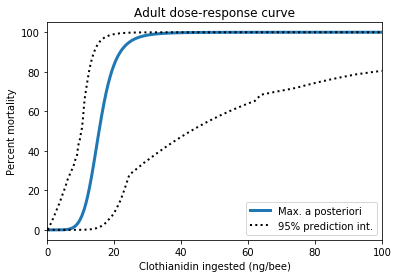

In [15]:
#for adults
random.seed(1251)
plot_dr_map(df, percent=95, xlim=100, title = "Adult dose-response curve")

Another way to vizualize, showing 100 possible dose-response curves

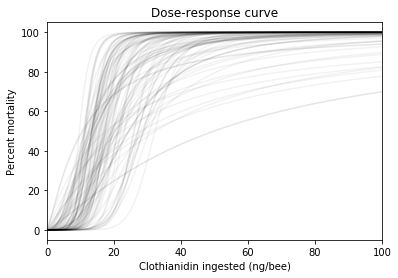

In [17]:
random.seed(1251)
sample = draw_posterior(df, w, 100)
plot_all_dr(sample, xlim=100, adult=True)

Now lets compare to larva dose-response

It's clearly much less certain

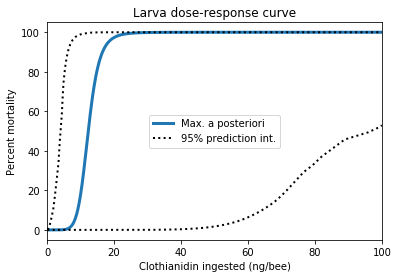

In [18]:
random.seed(1251)
plot_dr_map(df, percent=95, adult=False, title = "Larva dose-response curve")

#### Now let's make predictions about colony health 

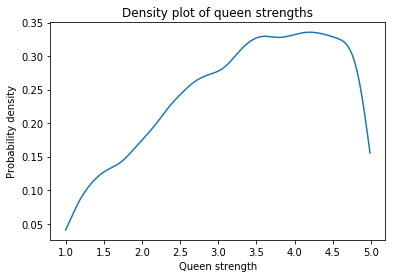

In [19]:
# define some helper functions
def plot_queenstrength(sample_in, mean_col = 6, sd_col = 7, title='Density plot of queen strengths',):
    sample = sample_in.reset_index(drop=True)
    lower = 1
    upper = 5
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .01)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel='Queen strength', ylabel='Probability density', title=title)
    plt.show()

random.seed(1251)
sample = draw_posterior(df,w,200)
plot_queenstrength(sample)
    

These histograms will tell us the predicted distribution of queen strengths and forager lifespans for the colonies in the feeding study.

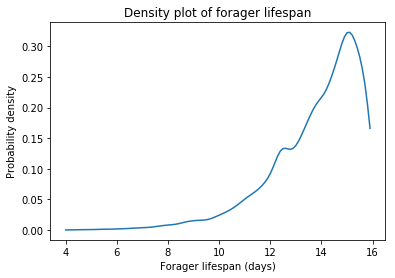

In [20]:
def plot_foragerlifespan(sample_in, mean_col = 4, sd_col=5, title='Density plot of forager lifespan',):
    sample = sample_in.reset_index(drop=True)
    lower = 4
    upper = 16
    values = np.empty([len(sample.index), 84]) #some number of posterior samples x 84 hives
    fix, ax = plt.subplots()
    for index, row in sample.iterrows():
        mu = row[mean_col]
        sigma = row[sd_col]
        values[index] = st.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=84)#draw our 84 study hives
    values_flat = values.flatten()
    density = st.kde.gaussian_kde(values_flat)
    x = np.arange(lower, upper, .1)
    ax.plot(x, density(x)) #for a density plot
    #ax.hist(values_flat) #for a histogram
    ax.set(xlabel='Forager lifespan (days)', ylabel='Probability density', title=title)
    plt.show()
    
random.seed(1251)
sample = draw_posterior(df,w,200)
plot_foragerlifespan(sample)